In [2]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from pyramid.arima import auto_arima

from Sloth.Sloth import Sloth
Sloth = Sloth()

/home/jgleason/.local/lib/python3.5/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)
Using TensorFlow backend.


In [31]:
# read and preprocess data
data_index = pd.read_csv("datasets/index.csv")
data_index['start_ind'][0] = 0
data = pd.read_csv("datasets/data.csv")

# bin tweets by hour
tweet_index = 0
s_per_hr = 3600
s_per_min = 60
s_per_10_min = 360
train_splits = [x / 100 for x in range(1,11,1)]
retweets = data['relative_time_second'][data_index['start_ind'][tweet_index] + 1:data_index['end_ind'][tweet_index]]
hourly = pd.cut(retweets, range(int(retweets.values[0]), int(retweets.values[len(retweets.values) - 1]) + s_per_hr,s_per_hr))
bin_hourly = retweets.groupby(hourly).agg('count')
#bin_hourly = Sloth.ScaleSeriesMinMax(bin_hourly, -1, 1)[0]
bin_hourly = pd.DataFrame(data = bin_hourly.values, index = range(len(bin_hourly)))
print(bin_hourly.shape)
bin_hourly.columns = ['tweet_count']
print(bin_hourly.head())

/home/jgleason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(95, 1)
   tweet_count
0          106
1           25
2            4
3            5
4            3


In [4]:
# function that plots time series data
# parameters:
#     input_data:                input data frame to plot
#     title:                     string to represent time series data, to be used as title / ylabel

def plot_data(input_data, title):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.plot(input_data.index, input_data.values, "k-")
    plt.xlabel("Year")
    plt.ylabel(title)
    plt.title(title)
 
# function that plots time series seasonal decomposition
# parameters:
#     input_data:                input data frame 
#     frequency:                 frequency, or periodicity, of the time series
def plot_seasonal(input_data, *frequency):
    if not frequency:
        result = Sloth.DecomposeSeriesSeasonal(input_data.index, input_data.values)
    else:
        result = Sloth.DecomposeSeriesSeasonal(input_data.index, input_data.values, frequency[0])
    fig = result.plot()
    plt.xlabel("Hour")
    plt.show()

# function that makes a future forecast for time series data
# parameters:
#     train:                     input training data frame
#     test:                      input testing data frame
#     seasonal:                  boolean; whether data has seasonal component
#     seasonal_differencing      period for seasonal differencing

def future_forecast(train, test, seasonal, *seasonal_differencing):
    
    print("DEBUG::the size of test is:")
    print(test.shape)
    
    '''
    if not seasonal_differencing:
        future_forecast = Sloth.PredictSeriesARIMA(train,test.shape[0],seasonal)
    else:
        future_forecast = Sloth.PredictSeriesARIMA(train,test.shape[0],seasonal, seasonal_differencing[0])
    '''
    if not seasonal_differencing:
            stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=1, start_Q = 1, seasonal=seasonal,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=False, 
                            stepwise=True)
        # specified seasonal differencing parameter
    else:
        stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=seasonal_differencing[0],
                            start_P=1, start_Q = 1, seasonal=seasonal,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=False, 
                            stepwise=True)
    stepwise_model.fit(train)
    future_forecast = stepwise_model.predict(n_periods=test.shape[0])
    print("DEBUG::Future forecast:")
    print(future_forecast)

    future_forecast = pd.DataFrame(future_forecast,index = test.index, columns=["Prediction"])
    return future_forecast


# function that plots time series data
# parameters:
#     input_data:                input data frame to plot
#     future_forecast:           future forecast for time series data
#     title:                     string to represent time series data, to be used as title / ylabel
def plot_future_forecast(input_data, test, future_forecast, title):
    plt.subplot(2, 1, 1)
    plt.plot(pd.concat([test,future_forecast],axis=1).index, pd.concat([test,future_forecast],axis=1).values)
    plt.xlabel("data point index")
    plt.ylabel(title)
    plt.title(title)
    plt.subplot(2, 1, 2)
    plt.plot(pd.concat([input_data,future_forecast],axis=1).index, pd.concat([input_data,future_forecast],axis=1).values)
    plt.xlabel("Hour")
    plt.ylabel(title)

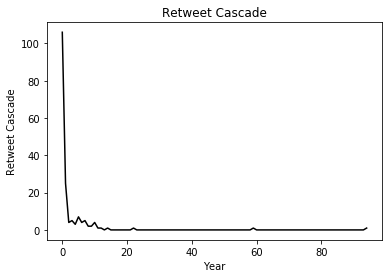

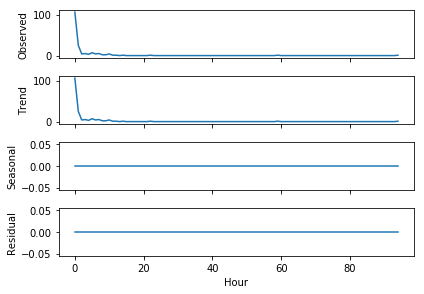

DEBUG::the size of test is:
(48, 1)
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=364.466, BIC=368.124, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0); AIC=347.683, BIC=353.168, Fit time=0.094 seconds
Fit ARIMA: order=(0, 1, 1); AIC=344.300, BIC=349.786, Fit time=0.045 seconds


/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

Fit ARIMA: order=(0, 1, 2); AIC=340.083, BIC=347.397, Fit time=0.090 seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 3); AIC=330.309, BIC=339.452, Fit time=0.156 seconds


/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds


/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/jgleason/.local/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


Fit ARIMA: order=(0, 1, 4); AIC=331.733, BIC=342.705, Fit time=0.267 seconds
Total fit time: 0.779 seconds
DEBUG::Future forecast:
[   0.69373113   -1.32145747   -5.65498761  -12.5159329   -19.3768782
  -26.23782349  -33.09876878  -39.95971408  -46.82065937  -53.68160467
  -60.54254996  -67.40349525  -74.26444055  -81.12538584  -87.98633114
  -94.84727643 -101.70822173 -108.56916702 -115.43011231 -122.29105761
 -129.1520029  -136.0129482  -142.87389349 -149.73483878 -156.59578408
 -163.45672937 -170.31767467 -177.17861996 -184.03956526 -190.90051055
 -197.76145584 -204.62240114 -211.48334643 -218.34429173 -225.20523702
 -232.06618231 -238.92712761 -245.7880729  -252.6490182  -259.50996349
 -266.37090878 -273.23185408 -280.09279937 -286.95374467 -293.81468996
 -300.67563526 -307.53658055 -314.39752584]


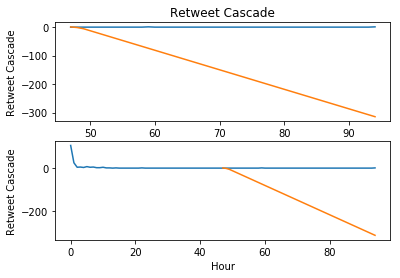

In [34]:
# plots and forecasting for electronic production
from scipy import stats
bin_hourly = retweets.groupby(hourly).agg('count')
#bin_hourly = Sloth.ScaleSeriesMinMax(bin_hourly, -1, 1)[0]
bin_hourly = pd.DataFrame(data = bin_hourly.values, index = range(len(bin_hourly)))
bin_hourly.columns = ['tweet_count']
#bin_hourly['tweet_count'] = [i + 1 for i in bin_hourly['tweet_count']]
#bin_hourly_t, lam = stats.boxcox(bin_hourly)
#bin_hourly = pd.DataFrame(data = bin_hourly_t, index = range(len(bin_hourly_t)))
#bin_hourly['tweet_count'] = [math.log(i) if i > 0 else 0 for i in bin_hourly['tweet_count']]
plot_data(bin_hourly, "Retweet Cascade")
plot_seasonal(bin_hourly)

# use 80% of data as training data
train_split = int(.5* len(bin_hourly))
train = bin_hourly[:train_split]
test = bin_hourly[train_split:]
future_forecast_tweets = future_forecast(train, test, False, 24)
plot_future_forecast(bin_hourly, test, future_forecast_tweets, 'Retweet Cascade')

[1001.0, 501.0, 251.0, 126.0, 63.5, 32.25, 16.625, 8.8125, 4.90625, 2.953125, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1.13436452 1.13217618 1.12816139 1.12081623 1.10745219 1.08340078
 1.04102235 0.9692838  0.85629091 0.69831773 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
-0.87952649162399


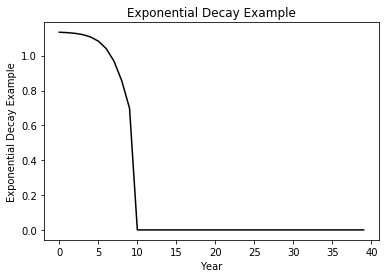

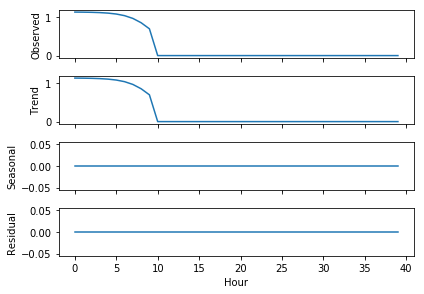

DEBUG::the size of test is:
(10, 1)
Fit ARIMA: order=(1, 1, 1); AIC=-27.084, BIC=-21.755, Fit time=0.076 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-29.976, BIC=-27.312, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-28.993, BIC=-24.996, Fit time=0.042 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-28.853, BIC=-24.856, Fit time=0.046 seconds
Total fit time: 0.174 seconds
DEBUG::Future forecast:
[-0.04051302 -0.08102604 -0.12153906 -0.16205208 -0.2025651  -0.24307812
 -0.28359114 -0.32410416 -0.36461719 -0.40513021]


/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/jgleason/.local/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

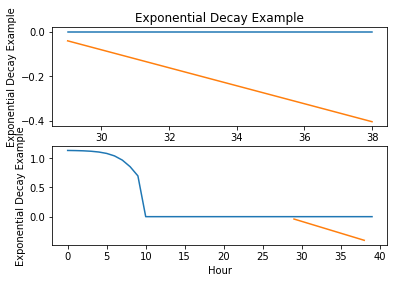

In [12]:
# test simple exponential decay example
import math

X_train = [1000*0.5**i for i in range(10)]
X_test = [0 for i in range(10)]
data = X_train + X_test + X_test + X_test
#data = Sloth.ScaleSeriesMeanVariance(data)[0]
#data = [math.log(i) if i > 0 else 0 for i in data]
data = [i + 1 for i in data]
print(data)
data_t, lam = stats.boxcox(data)
print(data_t)
print(lam)
data = pd.DataFrame(data_t)
X_train = data[:29]
X_test = data[30:]
X_test.index = [i + len(X_train) for i in range(len(X_test))]

plot_data(data, "Exponential Decay Example")
plt.show()
plot_seasonal(data)

future_forecast_exp = future_forecast(X_train, X_test, False)
plot_future_forecast(data, X_test, future_forecast_exp, 'Exponential Decay Example')
